In [12]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from tqdm import tqdm

### Get MNIST

In [13]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


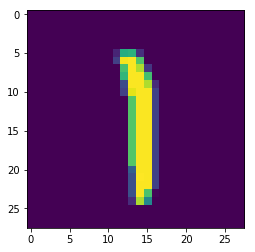

In [14]:
plt.imshow(mnist.train.next_batch(1)[0].reshape((28,28)))
plt.show()

### Create graph for train

In [15]:
BATCH_SIZE = 256
routing_iterations = 3
NCLASSES = 10

#### squash, capsule, dynamic routing

In [16]:
def squash(input):
    sj2 = tf.reduce_sum(tf.square(input), axis=-1, keep_dims=True)
    scale = sj2 / (1. + sj2)
    return scale * (input / tf.sqrt(sj2+1e-9))
def build_capsule(input, input_channels=256, output_channels=8, filter_size=9, stride=2 ):
    # w.shape = [8,8,256,8]
    cap = tf.layers.conv2d(
            inputs=input,
            filters=output_channels,
            kernel_size=[filter_size, filter_size],
            strides=(stride, stride),
            padding="valid",
            use_bias=True,
            kernel_initializer=tf.truncated_normal_initializer(stddev=0.1),
            activation=None)
    return squash(cap)
def dynamic_routing(input):
    # 2: for all capsule i in layer l and capsule j in layer (l + 1): bij ← 0.
    # b_ij: [1, num_caps, num_outputs, 1, 1]
    b_ij = tf.constant(np.zeros([1, input.shape[1].value, NCLASSES, 1, 1], dtype=np.float32))
    # W is [8,16] for each [1,32*6*6] feature maps conveying [1,10], so:
    with tf.variable_scope("dyn_rout"):
        W = tf.get_variable('W', shape=(1, input.shape[1].value, NCLASSES, 8, 16), dtype=tf.float32, 
                        initializer=tf.random_normal_initializer(stddev=0.02))

    # repeat input and W => [batch, 1152, 10, 8, 1]
    # W => [batch, 1152, 10, 8, 16]
    input = tf.tile(input, [1, 1, NCLASSES, 1, 1])
    W = tf.tile(W, [BATCH_SIZE, 1, 1, 1, 1])
    # [8,16]'*[8,1] = [16, 1] => [batch_size, 1152, 10, 16, 1]
    u_hat = tf.matmul(W, input, transpose_a=True)
    # 3: for r iterations do
    for r_ite in range(routing_iterations):
        print("iteration ", r_ite)
        with tf.variable_scope(str(r_ite)):
            # for all capsule i in layer l: ci ← softmax(bi
            c_ij = tf.nn.softmax(b_ij, dim=2)
            c_ij = tf.tile(c_ij, [BATCH_SIZE, 1, 1, 1, 1])
            # for all capsule j in layer (l + 1): sj <= SUM cijˆuj|i
            s_j = tf.multiply(c_ij, u_hat)
            s_j = tf.reduce_sum(s_j, axis=1, keep_dims=True)
            v_j = squash(s_j)
            v_j_tile = tf.tile(v_j, [1, input.shape[1].value, 1, 1, 1])
            u_v_product = tf.matmul(u_hat, v_j_tile, transpose_a=True)
            # for all capsule i in layer l and capsule j in layer (l + 1): bij ← bij + ˆuj|i.vj
            b_ij = b_ij + tf.reduce_sum(u_v_product, axis=0, keep_dims=True)
            print("c_ij",c_ij)
            print("s_j",s_j)
            print("v_j",v_j)
            print("v_j_tile",v_j_tile)
            print("v_j",u_v_product)
    return(v_j)
def decoder(input):
    v_j = tf.reshape(input, shape=(BATCH_SIZE, -1))
    dense1 = tf.contrib.layers.fully_connected(v_j, num_outputs=512)
    dense2 = tf.contrib.layers.fully_connected(dense1, num_outputs=1024)
    return tf.contrib.layers.fully_connected(dense2, num_outputs=784, activation_fn=tf.sigmoid)


In [ ]:
class CapsNet():
    def __init__(self, sess=None):
        self.n_classes = 10
        self.output_len = 16
        self.caps_len = 8
        self.BATCH_SIZE = 256
        self.sess = sess

        self.x = tf.placeholder(tf.float32, shape=(self.BATCH_SIZE, 28*28))
        self.y = tf.placeholder(tf.float32, [self.BATCH_SIZE, self.n_classes])
    def build_graph(self):
        with tf.variable_scope('conv_1'):
            x_reshape = tf.reshape(self.x, shape=[-1,28,28,1])
            self.conv1 = tf.layers.conv2d(
                inputs=x_reshape,
                filters=256,
                kernel_size=[9, 9],
                padding="valid",
                use_bias=True,
                activation=tf.nn.relu)
        with tf.variable_scope('primary_caps'):
            prim_caps_chan = 32
            caps = []
            for i in range(prim_caps_chan):
                # "8 convolutional units with a 9 × 9 kernel and a stride of 2 "
                cap = build_capsule(self.conv1, 256, self.caps_len, 9, 2)
                to_concat = tf.expand_dims(cap, axis=1)
                # to_concat.shape = [batch, 1, 6, 6, 8]
                caps.append(to_concat)
            self.primary_caps = tf.concat(caps, axis=1, name="primary_caps")
            
        with tf.variable_scope('digit_caps'):
            primary_caps_shape = self.primary_caps.shape.as_list()
            n_feature_maps = primary_caps_shape[1]*primary_caps_shape[2]*primary_caps_shape[3]
            self.primary_caps = tf.reshape(self.primary_caps, shape=[-1, n_feature_maps, 1, self.caps_len, 1])           
            # dynamic routing
            digit_caps = dynamic_routing(self.primary_caps)
            self.v_j = tf.reshape(digit_caps, shape=[-1, self.n_classes, self.output_len, 1])
            self.v_j_norm = tf.squeeze(tf.norm(self.v_j, axis=2))
                
        with tf.variable_scope('decoder'):
            masked_digit_caps = tf.multiply(tf.squeeze(self.v_j), tf.reshape(self.y, (-1, self.n_classes, 1)))
            masked_digit_caps = tf.reduce_sum(masked_digit_caps, axis=1)
            self.reconstructed = decoder(masked_digit_caps)
            
        # losses
        regularization_scale = 0.0005
        m_plus = 0.9
        m_minus = 0.1
        lambda_loss = 0.5
        self.v_j_abs = tf.sqrt(tf.reduce_sum(tf.square(self.v_j), axis=2, keep_dims=True))
        positive = tf.reshape(tf.square(tf.maximum(0.0, m_plus - self.v_j_abs)), shape=(BATCH_SIZE, -1))
        negative = tf.reshape(tf.square(tf.maximum(0.0, self.v_j_abs - m_minus)), shape=(BATCH_SIZE, -1))
        # T_c is just like y (one-hot), and each output capsule has its loss, so we sum it
        T_c = self.y
        self.margin_loss = tf.reduce_mean(tf.reduce_sum(T_c*positive+lambda_loss*(1 - T_c)*negative, axis=1))
        sum_squared = tf.reduce_sum(tf.square(self.reconstructed - tf.reshape(self.x, shape=(BATCH_SIZE, -1))),axis=-1) 
        self.decoder_loss = tf.reduce_mean(sum_squared)
        self.total_loss = self.margin_loss + regularization_scale*self.decoder_loss
        self.opt = tf.train.AdamOptimizer().minimize(self.total_loss)
        self.saver = tf.train.Saver()

        
    def train(self, n_epocs=5):
        tf.global_variables_initializer().run()
        batch_num = int(mnist.train.num_examples/self.BATCH_SIZE)
        total_batches = int(mnist.train.num_examples/self.BATCH_SIZE)
        for epoch in tqdm(range(n_epocs)):
            print("epoch {0}".format(epoch))
            for batch in tqdm(range(total_batches)):
                batch_train = mnist.train.next_batch(self.BATCH_SIZE)
                x_ = batch_train[0] #input_x[step*self.BATCH_SIZE:(step+1)*self.BATCH_SIZE]
                y_ = batch_train[1] #label_y[step*self.BATCH_SIZE:(step+1)*self.BATCH_SIZE]
                _, total_loss, margin_loss, decoder_loss, reconstructed = self.sess.run(
                    [self.opt, 
                    self.total_loss, 
                    self.margin_loss,
                    self.decoder_loss,
                    self.reconstructed], 
                    feed_dict={self.x: x_, self.y: y_})
                print("total loss:",total_loss,"margin loss",margin_loss,"decoder loss",decoder_loss )
            plt.imshow(np.array(reconstructed[0]).reshape((28,28)))
            plt.show()
    def test(self):
        tf.global_variables_initializer().run()
        accuracy = 0
        for batch in tqdm(range(int(mnist.test.num_examples/self.BATCH_SIZE))):
            
            batch_test = mnist.test.next_batch(self.BATCH_SIZE)
            x_ = batch_test[0] #input_x[step*self.BATCH_SIZE:(step+1)*self.BATCH_SIZE]
            y_ = batch_test[1] #label_y[step*self.BATCH_SIZE:(step+1)*self.BATCH_SIZE]
            
            real_labels = np.argmax(np.array(y_),axis=1)
            
            v_j_norm = self.sess.run(self.v_j_norm, feed_dict={self.x: batch_x})
            pred_labels =  np.argmax(np.array(v_j_norm),axis=1)
            
            batch_acc = np.sum(np.array(np.equal(np_batch_y, v_j_norm)).astype(np.float))
            
            accuracy = accuracy + batch_acc
            print("batch:[%d]" %(step), "batch_acc", batch_acc)
        print("accuracy:", accuracy/(self.BATCH_SIZE*(batch_num-1)))
        

In [ ]:
tf.reset_default_graph()
with tf.Session() as sess:
    Caps = CapsNet(sess=sess)
    Caps.build_graph()
    Caps.train()

iteration  0
c_ij Tensor("digit_caps/0/Tile:0", shape=(256, 1152, 10, 1, 1), dtype=float32)
s_j Tensor("digit_caps/0/Sum:0", shape=(256, 1, 10, 16, 1), dtype=float32)
v_j Tensor("digit_caps/0/mul:0", shape=(256, 1, 10, 16, 1), dtype=float32)
v_j_tile Tensor("digit_caps/0/Tile_1:0", shape=(256, 1152, 10, 16, 1), dtype=float32)
v_j Tensor("digit_caps/0/MatMul:0", shape=(256, 1152, 10, 1, 1), dtype=float32)
iteration  1
c_ij Tensor("digit_caps/1/Tile:0", shape=(256, 1152, 10, 1, 1), dtype=float32)
s_j Tensor("digit_caps/1/Sum:0", shape=(256, 1, 10, 16, 1), dtype=float32)
v_j Tensor("digit_caps/1/mul:0", shape=(256, 1, 10, 16, 1), dtype=float32)
v_j_tile Tensor("digit_caps/1/Tile_1:0", shape=(256, 1152, 10, 16, 1), dtype=float32)
v_j Tensor("digit_caps/1/MatMul:0", shape=(256, 1152, 10, 1, 1), dtype=float32)
iteration  2
c_ij Tensor("digit_caps/2/Tile:0", shape=(256, 1152, 10, 1, 1), dtype=float32)
s_j Tensor("digit_caps/2/Sum:0", shape=(256, 1, 10, 16, 1), dtype=float32)
v_j Tensor("digit

  0%|          | 0/214 [00:00<?, ?it/s]

epoch 0



  0%|          | 1/214 [00:03<11:40,  3.29s/it]

total loss: 0.878187 margin loss 0.787419 decoder loss 181.536



  1%|          | 2/214 [00:06<10:51,  3.07s/it]

total loss: 9.34459 margin loss 9.25397 decoder loss 181.239



  1%|▏         | 3/214 [00:09<10:39,  3.03s/it]

total loss: 8.81731 margin loss 8.72799 decoder loss 178.643



  2%|▏         | 4/214 [00:11<10:23,  2.97s/it]

total loss: 2.645 margin loss 2.55552 decoder loss 178.962



  2%|▏         | 5/214 [00:14<10:12,  2.93s/it]

total loss: 3.90768 margin loss 3.81928 decoder loss 176.809



  3%|▎         | 6/214 [00:17<10:07,  2.92s/it]

total loss: 0.830065 margin loss 0.741069 decoder loss 177.991



  3%|▎         | 7/214 [00:20<10:06,  2.93s/it]

total loss: 0.817321 margin loss 0.728864 decoder loss 176.916



  4%|▎         | 8/214 [00:23<10:01,  2.92s/it]

total loss: 0.859862 margin loss 0.772333 decoder loss 175.058



  4%|▍         | 9/214 [00:26<09:58,  2.92s/it]

total loss: 0.873559 margin loss 0.787462 decoder loss 172.194



  5%|▍         | 10/214 [00:29<09:55,  2.92s/it]

total loss: 0.880611 margin loss 0.796141 decoder loss 168.94



  5%|▌         | 11/214 [00:32<09:52,  2.92s/it]

total loss: 0.883751 margin loss 0.801357 decoder loss 164.788



  6%|▌         | 12/214 [00:34<09:46,  2.90s/it]

total loss: 0.883302 margin loss 0.803722 decoder loss 159.161



  6%|▌         | 13/214 [00:37<09:43,  2.90s/it]

total loss: 0.882233 margin loss 0.805869 decoder loss 152.728



  7%|▋         | 14/214 [00:40<09:41,  2.91s/it]

total loss: 0.879444 margin loss 0.807076 decoder loss 144.735



  7%|▋         | 15/214 [00:43<09:39,  2.91s/it]

total loss: 0.875443 margin loss 0.807505 decoder loss 135.875



  7%|▋         | 16/214 [00:46<09:36,  2.91s/it]

total loss: 0.870725 margin loss 0.808119 decoder loss 125.212



  8%|▊         | 17/214 [00:49<09:31,  2.90s/it]

total loss: 0.865614 margin loss 0.808515 decoder loss 114.199



  8%|▊         | 18/214 [00:52<09:29,  2.90s/it]

total loss: 0.860305 margin loss 0.808689 decoder loss 103.233



  9%|▉         | 19/214 [00:55<09:25,  2.90s/it]

total loss: 0.854551 margin loss 0.808806 decoder loss 91.4901



  9%|▉         | 20/214 [00:57<09:22,  2.90s/it]

total loss: 0.850081 margin loss 0.809078 decoder loss 82.0074



 10%|▉         | 21/214 [01:00<09:20,  2.90s/it]

total loss: 0.845394 margin loss 0.809168 decoder loss 72.4517



 10%|█         | 22/214 [01:03<09:17,  2.91s/it]

total loss: 0.843056 margin loss 0.809231 decoder loss 67.6501



 11%|█         | 23/214 [01:06<09:15,  2.91s/it]

total loss: 0.839692 margin loss 0.809207 decoder loss 60.9703



 11%|█         | 24/214 [01:09<09:14,  2.92s/it]

total loss: 0.838485 margin loss 0.809325 decoder loss 58.3213



 12%|█▏        | 25/214 [01:12<09:11,  2.92s/it]

total loss: 0.83807 margin loss 0.809376 decoder loss 57.3889



 12%|█▏        | 26/214 [01:15<09:09,  2.92s/it]

total loss: 0.838436 margin loss 0.809429 decoder loss 58.0121



 13%|█▎        | 27/214 [01:18<09:06,  2.92s/it]

total loss: 0.838175 margin loss 0.809409 decoder loss 57.5317



 13%|█▎        | 28/214 [01:21<09:03,  2.92s/it]

total loss: 0.83893 margin loss 0.809446 decoder loss 58.9678



 14%|█▎        | 29/214 [01:24<08:59,  2.91s/it]

total loss: 0.837368 margin loss 0.80942 decoder loss 55.8963



 14%|█▍        | 30/214 [01:27<08:56,  2.91s/it]

total loss: 0.83574 margin loss 0.809399 decoder loss 52.6822



 14%|█▍        | 31/214 [01:30<08:53,  2.91s/it]

total loss: 0.837793 margin loss 0.809403 decoder loss 56.7806



 15%|█▍        | 32/214 [01:33<08:50,  2.92s/it]

total loss: 0.837857 margin loss 0.809413 decoder loss 56.8867



 15%|█▌        | 33/214 [01:36<08:47,  2.92s/it]

total loss: 0.837681 margin loss 0.809438 decoder loss 56.4852



 16%|█▌        | 34/214 [01:39<08:44,  2.92s/it]

total loss: 0.837866 margin loss 0.809501 decoder loss 56.7309



 16%|█▋        | 35/214 [01:42<08:42,  2.92s/it]

total loss: 0.838114 margin loss 0.809508 decoder loss 57.2116



 17%|█▋        | 36/214 [01:45<08:40,  2.92s/it]

total loss: 0.837418 margin loss 0.809388 decoder loss 56.0593



 17%|█▋        | 37/214 [01:48<08:36,  2.92s/it]

total loss: 0.837199 margin loss 0.809484 decoder loss 55.4304



 18%|█▊        | 38/214 [01:51<08:34,  2.92s/it]

total loss: 0.836654 margin loss 0.809465 decoder loss 54.3793



 18%|█▊        | 39/214 [01:54<08:31,  2.92s/it]

total loss: 0.837031 margin loss 0.809401 decoder loss 55.2583



 19%|█▊        | 40/214 [01:56<08:27,  2.92s/it]

total loss: 0.836173 margin loss 0.809426 decoder loss 53.494



 19%|█▉        | 41/214 [01:59<08:25,  2.92s/it]

total loss: 0.837402 margin loss 0.809365 decoder loss 56.0751



 20%|█▉        | 42/214 [02:02<08:21,  2.92s/it]

total loss: 0.835712 margin loss 0.809327 decoder loss 52.7697



 20%|██        | 43/214 [02:05<08:18,  2.91s/it]

total loss: 0.836317 margin loss 0.809327 decoder loss 53.9803



 21%|██        | 44/214 [02:08<08:15,  2.91s/it]

total loss: 0.836177 margin loss 0.809237 decoder loss 53.8795



 21%|██        | 45/214 [02:10<08:11,  2.91s/it]

total loss: 0.83702 margin loss 0.809375 decoder loss 55.2899



 21%|██▏       | 46/214 [02:13<08:08,  2.91s/it]

total loss: 0.836276 margin loss 0.809204 decoder loss 54.1453



 22%|██▏       | 47/214 [02:16<08:04,  2.90s/it]

total loss: 0.83545 margin loss 0.80915 decoder loss 52.6006



 22%|██▏       | 48/214 [02:19<08:01,  2.90s/it]

total loss: 0.83687 margin loss 0.809242 decoder loss 55.2562



 23%|██▎       | 49/214 [02:22<07:58,  2.90s/it]

total loss: 0.83726 margin loss 0.809161 decoder loss 56.198



 23%|██▎       | 50/214 [02:24<07:55,  2.90s/it]

total loss: 0.836355 margin loss 0.809126 decoder loss 54.4574



 24%|██▍       | 51/214 [02:27<07:52,  2.90s/it]

total loss: 0.835259 margin loss 0.808744 decoder loss 53.0298



 24%|██▍       | 52/214 [02:30<07:49,  2.90s/it]

total loss: 0.835391 margin loss 0.808852 decoder loss 53.0782



 25%|██▍       | 53/214 [02:33<07:46,  2.90s/it]

total loss: 0.836142 margin loss 0.808812 decoder loss 54.6599



 25%|██▌       | 54/214 [02:36<07:43,  2.90s/it]

total loss: 0.834866 margin loss 0.80829 decoder loss 53.1519



 26%|██▌       | 55/214 [02:39<07:40,  2.90s/it]

total loss: 0.834668 margin loss 0.807938 decoder loss 53.46



 26%|██▌       | 56/214 [02:42<07:37,  2.90s/it]

total loss: 0.834589 margin loss 0.807679 decoder loss 53.8207



 27%|██▋       | 57/214 [02:44<07:34,  2.89s/it]

total loss: 0.833508 margin loss 0.806199 decoder loss 54.6178



 27%|██▋       | 58/214 [02:47<07:31,  2.89s/it]

total loss: 0.831482 margin loss 0.803746 decoder loss 55.4738



 28%|██▊       | 59/214 [02:50<07:28,  2.89s/it]

total loss: 0.822041 margin loss 0.795971 decoder loss 52.1399



 28%|██▊       | 60/214 [02:53<07:25,  2.89s/it]

total loss: 0.805838 margin loss 0.778947 decoder loss 53.7834



 29%|██▊       | 61/214 [02:56<07:22,  2.89s/it]

total loss: 0.747984 margin loss 0.721153 decoder loss 53.6615



 29%|██▉       | 62/214 [02:59<07:19,  2.89s/it]

total loss: 1.4157 margin loss 1.39029 decoder loss 50.8362



 29%|██▉       | 63/214 [03:02<07:16,  2.89s/it]

total loss: 0.735444 margin loss 0.708232 decoder loss 54.424



 30%|██▉       | 64/214 [03:04<07:13,  2.89s/it]

total loss: 0.783741 margin loss 0.756884 decoder loss 53.7141



 30%|███       | 65/214 [03:07<07:10,  2.89s/it]

total loss: 0.804224 margin loss 0.777437 decoder loss 53.5732



 31%|███       | 66/214 [03:10<07:08,  2.89s/it]

total loss: 0.81947 margin loss 0.79358 decoder loss 51.7787



 31%|███▏      | 67/214 [03:13<07:05,  2.89s/it]

total loss: 0.824962 margin loss 0.798026 decoder loss 53.8713



 32%|███▏      | 68/214 [03:16<07:02,  2.89s/it]

total loss: 0.828421 margin loss 0.801496 decoder loss 53.849



 32%|███▏      | 69/214 [03:19<06:59,  2.89s/it]

total loss: 0.830049 margin loss 0.804047 decoder loss 52.004



 33%|███▎      | 70/214 [03:22<06:56,  2.89s/it]

total loss: 0.832841 margin loss 0.806208 decoder loss 53.2665



 33%|███▎      | 71/214 [03:25<06:53,  2.89s/it]

total loss: 0.834428 margin loss 0.807162 decoder loss 54.5315



 34%|███▎      | 72/214 [03:28<06:50,  2.89s/it]

total loss: 0.834184 margin loss 0.807935 decoder loss 52.4981



 34%|███▍      | 73/214 [03:31<06:48,  2.90s/it]

total loss: 0.834803 margin loss 0.808057 decoder loss 53.4912



 35%|███▍      | 74/214 [03:34<06:45,  2.89s/it]

total loss: 0.835 margin loss 0.808504 decoder loss 52.9925



 35%|███▌      | 75/214 [03:36<06:42,  2.89s/it]

total loss: 0.836031 margin loss 0.808849 decoder loss 54.3625



 36%|███▌      | 76/214 [03:39<06:39,  2.89s/it]

total loss: 0.835311 margin loss 0.8091 decoder loss 52.4231



 36%|███▌      | 77/214 [03:42<06:36,  2.90s/it]

total loss: 0.83563 margin loss 0.809078 decoder loss 53.1043



 36%|███▋      | 78/214 [03:45<06:33,  2.90s/it]

total loss: 0.835497 margin loss 0.809335 decoder loss 52.3248



 37%|███▋      | 79/214 [03:48<06:31,  2.90s/it]

total loss: 0.835627 margin loss 0.80899 decoder loss 53.2739



 37%|███▋      | 80/214 [03:51<06:28,  2.90s/it]

total loss: 0.836929 margin loss 0.809311 decoder loss 55.2357



 38%|███▊      | 81/214 [03:54<06:24,  2.89s/it]

total loss: 0.835768 margin loss 0.809329 decoder loss 52.8778



 38%|███▊      | 82/214 [03:57<06:22,  2.90s/it]

total loss: 0.834755 margin loss 0.80913 decoder loss 51.2498



 39%|███▉      | 83/214 [04:00<06:19,  2.89s/it]

total loss: 0.835504 margin loss 0.809186 decoder loss 52.6346



 39%|███▉      | 84/214 [04:03<06:16,  2.89s/it]

total loss: 0.835464 margin loss 0.809439 decoder loss 52.0497



 40%|███▉      | 85/214 [04:05<06:13,  2.89s/it]

total loss: 0.835604 margin loss 0.809596 decoder loss 52.0149



 40%|████      | 86/214 [04:08<06:10,  2.90s/it]

total loss: 0.835374 margin loss 0.809496 decoder loss 51.7575



 41%|████      | 87/214 [04:11<06:07,  2.90s/it]

total loss: 0.836135 margin loss 0.809473 decoder loss 53.3236



 41%|████      | 88/214 [04:14<06:04,  2.90s/it]

total loss: 0.836967 margin loss 0.809429 decoder loss 55.0756



 42%|████▏     | 89/214 [04:17<06:02,  2.90s/it]

total loss: 0.836986 margin loss 0.809227 decoder loss 55.5177



 42%|████▏     | 90/214 [04:20<05:59,  2.90s/it]

total loss: 0.836061 margin loss 0.809373 decoder loss 53.3763



 43%|████▎     | 91/214 [04:23<05:56,  2.90s/it]

total loss: 0.835628 margin loss 0.809152 decoder loss 52.9517



 43%|████▎     | 92/214 [04:26<05:53,  2.90s/it]

total loss: 0.836047 margin loss 0.809535 decoder loss 53.0251



 43%|████▎     | 93/214 [04:29<05:50,  2.90s/it]

total loss: 0.836201 margin loss 0.809654 decoder loss 53.0924



 44%|████▍     | 94/214 [04:32<05:47,  2.90s/it]

total loss: 0.836184 margin loss 0.809653 decoder loss 53.0628



 44%|████▍     | 95/214 [04:35<05:44,  2.90s/it]

total loss: 0.835584 margin loss 0.809451 decoder loss 52.2659



 45%|████▍     | 96/214 [04:37<05:41,  2.90s/it]

total loss: 0.836451 margin loss 0.809397 decoder loss 54.1063



 45%|████▌     | 97/214 [04:40<05:38,  2.90s/it]

total loss: 0.835536 margin loss 0.809526 decoder loss 52.0182



 46%|████▌     | 98/214 [04:44<05:36,  2.90s/it]

total loss: 0.836428 margin loss 0.809488 decoder loss 53.8801



 46%|████▋     | 99/214 [04:46<05:33,  2.90s/it]

total loss: 0.83582 margin loss 0.809545 decoder loss 52.5503



 47%|████▋     | 100/214 [04:49<05:30,  2.90s/it]

total loss: 0.836863 margin loss 0.809562 decoder loss 54.6022



 47%|████▋     | 101/214 [04:52<05:27,  2.90s/it]

total loss: 0.836171 margin loss 0.809327 decoder loss 53.6868



 48%|████▊     | 102/214 [04:55<05:24,  2.90s/it]

total loss: 0.835337 margin loss 0.809628 decoder loss 51.418



 48%|████▊     | 103/214 [04:58<05:21,  2.90s/it]

total loss: 0.836389 margin loss 0.80975 decoder loss 53.278



 49%|████▊     | 104/214 [05:01<05:19,  2.90s/it]

total loss: 0.836633 margin loss 0.809643 decoder loss 53.9808



 49%|████▉     | 105/214 [05:04<05:16,  2.90s/it]

total loss: 0.835925 margin loss 0.809463 decoder loss 52.924



 50%|████▉     | 106/214 [05:07<05:13,  2.90s/it]

total loss: 0.835944 margin loss 0.809435 decoder loss 53.0181



 50%|█████     | 107/214 [05:10<05:10,  2.90s/it]

total loss: 0.836141 margin loss 0.809403 decoder loss 53.4762



 50%|█████     | 108/214 [05:13<05:07,  2.90s/it]

total loss: 0.836014 margin loss 0.809436 decoder loss 53.157



 51%|█████     | 109/214 [05:16<05:04,  2.90s/it]

total loss: 0.83545 margin loss 0.809549 decoder loss 51.8017



 51%|█████▏    | 110/214 [05:19<05:01,  2.90s/it]

total loss: 0.836108 margin loss 0.809514 decoder loss 53.188



 52%|█████▏    | 111/214 [05:22<04:59,  2.90s/it]

total loss: 0.834895 margin loss 0.809554 decoder loss 50.6816



 52%|█████▏    | 112/214 [05:25<04:56,  2.90s/it]

total loss: 0.835753 margin loss 0.809595 decoder loss 52.3168



 53%|█████▎    | 113/214 [05:28<04:53,  2.90s/it]

total loss: 0.835767 margin loss 0.809241 decoder loss 53.0517



 53%|█████▎    | 114/214 [05:30<04:50,  2.90s/it]

total loss: 0.836766 margin loss 0.809558 decoder loss 54.4156



 54%|█████▎    | 115/214 [05:33<04:47,  2.90s/it]

total loss: 0.836206 margin loss 0.809276 decoder loss 53.8603



 54%|█████▍    | 116/214 [05:36<04:44,  2.90s/it]

total loss: 0.836347 margin loss 0.809556 decoder loss 53.5831



 55%|█████▍    | 117/214 [05:39<04:41,  2.90s/it]

total loss: 0.835984 margin loss 0.809552 decoder loss 52.8627



 55%|█████▌    | 118/214 [05:42<04:38,  2.90s/it]

total loss: 0.836754 margin loss 0.809046 decoder loss 55.4165



 56%|█████▌    | 119/214 [05:45<04:35,  2.90s/it]

total loss: 0.835527 margin loss 0.809517 decoder loss 52.0205



 56%|█████▌    | 120/214 [05:48<04:32,  2.90s/it]

total loss: 0.835183 margin loss 0.809588 decoder loss 51.1912



 57%|█████▋    | 121/214 [05:51<04:30,  2.90s/it]

total loss: 0.836572 margin loss 0.809376 decoder loss 54.3922



 57%|█████▋    | 122/214 [05:54<04:27,  2.90s/it]

total loss: 0.835535 margin loss 0.809326 decoder loss 52.4194



 57%|█████▋    | 123/214 [05:56<04:24,  2.90s/it]

total loss: 0.836123 margin loss 0.809386 decoder loss 53.4751



 58%|█████▊    | 124/214 [06:00<04:21,  2.90s/it]

total loss: 0.836054 margin loss 0.809698 decoder loss 52.7121



 58%|█████▊    | 125/214 [06:03<04:18,  2.90s/it]

total loss: 0.836479 margin loss 0.809334 decoder loss 54.2914



 59%|█████▉    | 126/214 [06:05<04:15,  2.90s/it]

total loss: 0.83615 margin loss 0.809118 decoder loss 54.0636



 59%|█████▉    | 127/214 [06:08<04:12,  2.90s/it]

total loss: 0.836156 margin loss 0.808986 decoder loss 54.339



 60%|█████▉    | 128/214 [06:11<04:09,  2.90s/it]

total loss: 0.836055 margin loss 0.809354 decoder loss 53.4027



 60%|██████    | 129/214 [06:14<04:06,  2.90s/it]

total loss: 0.836041 margin loss 0.809457 decoder loss 53.1683



 61%|██████    | 130/214 [06:17<04:03,  2.90s/it]

total loss: 0.835496 margin loss 0.809439 decoder loss 52.1135



 61%|██████    | 131/214 [06:20<04:00,  2.90s/it]

total loss: 0.835972 margin loss 0.809273 decoder loss 53.3986



 62%|██████▏   | 132/214 [06:23<03:57,  2.90s/it]

total loss: 0.836105 margin loss 0.80901 decoder loss 54.1914



 62%|██████▏   | 133/214 [06:25<03:54,  2.90s/it]

total loss: 0.835877 margin loss 0.809518 decoder loss 52.7176



 63%|██████▎   | 134/214 [06:28<03:52,  2.90s/it]

total loss: 0.835714 margin loss 0.808951 decoder loss 53.5266



 63%|██████▎   | 135/214 [06:31<03:49,  2.90s/it]

total loss: 0.835883 margin loss 0.809281 decoder loss 53.2041



 64%|██████▎   | 136/214 [06:34<03:46,  2.90s/it]

total loss: 0.836172 margin loss 0.809438 decoder loss 53.4697



 64%|██████▍   | 137/214 [06:37<03:43,  2.90s/it]

total loss: 0.835812 margin loss 0.80937 decoder loss 52.8837



 64%|██████▍   | 138/214 [06:40<03:40,  2.90s/it]

total loss: 0.836342 margin loss 0.809475 decoder loss 53.735



 65%|██████▍   | 139/214 [06:43<03:37,  2.90s/it]

total loss: 0.835514 margin loss 0.809487 decoder loss 52.0532



 65%|██████▌   | 140/214 [06:46<03:34,  2.90s/it]

total loss: 0.834837 margin loss 0.809425 decoder loss 50.823



 66%|██████▌   | 141/214 [06:49<03:31,  2.90s/it]

total loss: 0.836068 margin loss 0.809556 decoder loss 53.0247



 66%|██████▋   | 142/214 [06:52<03:28,  2.90s/it]

total loss: 0.836544 margin loss 0.809094 decoder loss 54.8997



 67%|██████▋   | 143/214 [06:54<03:26,  2.90s/it]

total loss: 0.834921 margin loss 0.808789 decoder loss 52.2635



 67%|██████▋   | 144/214 [06:57<03:23,  2.90s/it]

total loss: 0.835616 margin loss 0.80939 decoder loss 52.4515



 68%|██████▊   | 145/214 [07:00<03:20,  2.90s/it]

total loss: 0.835802 margin loss 0.809246 decoder loss 53.1119



 68%|██████▊   | 146/214 [07:03<03:17,  2.90s/it]

total loss: 0.834665 margin loss 0.809399 decoder loss 50.5327



 69%|██████▊   | 147/214 [07:06<03:14,  2.90s/it]

total loss: 0.836315 margin loss 0.809404 decoder loss 53.8214



 69%|██████▉   | 148/214 [07:08<03:11,  2.90s/it]

total loss: 0.834747 margin loss 0.808945 decoder loss 51.603



 70%|██████▉   | 149/214 [07:11<03:08,  2.90s/it]

total loss: 0.835787 margin loss 0.809131 decoder loss 53.3124



 70%|███████   | 150/214 [07:14<03:05,  2.90s/it]

total loss: 0.83552 margin loss 0.809355 decoder loss 52.3311



 71%|███████   | 151/214 [07:17<03:02,  2.90s/it]

total loss: 0.835092 margin loss 0.809256 decoder loss 51.6711



 71%|███████   | 152/214 [07:20<02:59,  2.90s/it]

total loss: 0.836058 margin loss 0.808941 decoder loss 54.2337



 71%|███████▏  | 153/214 [07:24<02:57,  2.90s/it]

total loss: 0.835315 margin loss 0.808862 decoder loss 52.9063



 72%|███████▏  | 154/214 [07:26<02:54,  2.90s/it]

total loss: 0.835515 margin loss 0.808969 decoder loss 53.0915



 72%|███████▏  | 155/214 [07:29<02:51,  2.90s/it]

total loss: 0.835475 margin loss 0.808946 decoder loss 53.0576



 73%|███████▎  | 156/214 [07:32<02:48,  2.90s/it]

total loss: 0.835659 margin loss 0.809267 decoder loss 52.785



 73%|███████▎  | 157/214 [07:35<02:45,  2.90s/it]

total loss: 0.834181 margin loss 0.808611 decoder loss 51.139



 74%|███████▍  | 158/214 [07:38<02:42,  2.90s/it]

total loss: 0.834697 margin loss 0.8087 decoder loss 51.9942



 74%|███████▍  | 159/214 [07:41<02:39,  2.90s/it]

total loss: 0.835584 margin loss 0.809206 decoder loss 52.755



 75%|███████▍  | 160/214 [07:44<02:36,  2.90s/it]

total loss: 0.835652 margin loss 0.809501 decoder loss 52.302



 75%|███████▌  | 161/214 [07:47<02:33,  2.90s/it]

total loss: 0.835223 margin loss 0.808394 decoder loss 53.657



 76%|███████▌  | 162/214 [07:50<02:30,  2.90s/it]

total loss: 0.835191 margin loss 0.809238 decoder loss 51.9063



 76%|███████▌  | 163/214 [07:53<02:28,  2.90s/it]

total loss: 0.835299 margin loss 0.808844 decoder loss 52.9101



 77%|███████▋  | 164/214 [07:56<02:25,  2.90s/it]

total loss: 0.835093 margin loss 0.80895 decoder loss 52.2863



 77%|███████▋  | 165/214 [07:59<02:22,  2.90s/it]

total loss: 0.835983 margin loss 0.808961 decoder loss 54.044



 78%|███████▊  | 166/214 [08:01<02:19,  2.90s/it]

total loss: 0.834821 margin loss 0.8081 decoder loss 53.4423



 78%|███████▊  | 167/214 [08:04<02:16,  2.90s/it]

total loss: 0.836112 margin loss 0.80911 decoder loss 54.0044



 79%|███████▊  | 168/214 [08:07<02:13,  2.90s/it]

total loss: 0.834064 margin loss 0.808128 decoder loss 51.8733



 79%|███████▉  | 169/214 [08:10<02:10,  2.90s/it]

total loss: 0.83517 margin loss 0.808481 decoder loss 53.3778



 79%|███████▉  | 170/214 [08:13<02:07,  2.90s/it]

total loss: 0.834778 margin loss 0.808149 decoder loss 53.2571



 80%|███████▉  | 171/214 [08:16<02:04,  2.90s/it]

total loss: 0.834535 margin loss 0.808388 decoder loss 52.2937



 80%|████████  | 172/214 [08:19<02:01,  2.90s/it]

total loss: 0.834295 margin loss 0.808415 decoder loss 51.7597



 81%|████████  | 173/214 [08:22<01:58,  2.90s/it]

total loss: 0.834144 margin loss 0.808169 decoder loss 51.9512



 81%|████████▏ | 174/214 [08:25<01:56,  2.90s/it]

total loss: 0.835339 margin loss 0.808822 decoder loss 53.0352



 82%|████████▏ | 175/214 [08:28<01:53,  2.90s/it]

total loss: 0.834549 margin loss 0.808503 decoder loss 52.0907



 82%|████████▏ | 176/214 [08:31<01:50,  2.90s/it]

total loss: 0.834611 margin loss 0.808055 decoder loss 53.1122



 83%|████████▎ | 177/214 [08:33<01:47,  2.90s/it]

total loss: 0.835844 margin loss 0.80838 decoder loss 54.9275



 83%|████████▎ | 178/214 [08:36<01:44,  2.90s/it]

total loss: 0.834992 margin loss 0.808376 decoder loss 53.2318



 84%|████████▎ | 179/214 [08:39<01:41,  2.90s/it]

total loss: 0.83551 margin loss 0.808431 decoder loss 54.1589



 84%|████████▍ | 180/214 [08:42<01:38,  2.90s/it]

total loss: 0.834585 margin loss 0.808019 decoder loss 53.1325



 85%|████████▍ | 181/214 [08:45<01:35,  2.90s/it]

total loss: 0.836428 margin loss 0.808613 decoder loss 55.6306



 85%|████████▌ | 182/214 [08:48<01:32,  2.90s/it]

total loss: 0.835237 margin loss 0.808724 decoder loss 53.0269



 86%|████████▌ | 183/214 [08:51<01:30,  2.90s/it]

total loss: 0.834213 margin loss 0.807808 decoder loss 52.81



 86%|████████▌ | 184/214 [08:54<01:27,  2.90s/it]

total loss: 0.834692 margin loss 0.808649 decoder loss 52.0862



 86%|████████▋ | 185/214 [08:57<01:24,  2.90s/it]

total loss: 0.833824 margin loss 0.808119 decoder loss 51.4094



 87%|████████▋ | 186/214 [08:59<01:21,  2.90s/it]

total loss: 0.834386 margin loss 0.80765 decoder loss 53.4717



 87%|████████▋ | 187/214 [09:02<01:18,  2.90s/it]

total loss: 0.833771 margin loss 0.80686 decoder loss 53.8219



 88%|████████▊ | 188/214 [09:05<01:15,  2.90s/it]

total loss: 0.834536 margin loss 0.808822 decoder loss 51.4295



 88%|████████▊ | 189/214 [09:08<01:12,  2.90s/it]

total loss: 0.834395 margin loss 0.80781 decoder loss 53.1683



 89%|████████▉ | 190/214 [09:11<01:09,  2.90s/it]

total loss: 0.834724 margin loss 0.807807 decoder loss 53.8333



 89%|████████▉ | 191/214 [09:14<01:06,  2.90s/it]

total loss: 0.833002 margin loss 0.806473 decoder loss 53.0585



 90%|████████▉ | 192/214 [09:17<01:03,  2.90s/it]

total loss: 0.834316 margin loss 0.807236 decoder loss 54.1592



 90%|█████████ | 193/214 [09:20<01:00,  2.90s/it]

total loss: 0.83373 margin loss 0.807038 decoder loss 53.383



 91%|█████████ | 194/214 [09:23<00:58,  2.90s/it]

total loss: 0.833184 margin loss 0.806615 decoder loss 53.1371



 91%|█████████ | 195/214 [09:26<00:55,  2.90s/it]

total loss: 0.834829 margin loss 0.808838 decoder loss 51.9819



 92%|█████████▏| 196/214 [09:28<00:52,  2.90s/it]

total loss: 0.832103 margin loss 0.805694 decoder loss 52.8198



 92%|█████████▏| 197/214 [09:31<00:49,  2.90s/it]

total loss: 0.832853 margin loss 0.807252 decoder loss 51.2016



 93%|█████████▎| 198/214 [09:34<00:46,  2.90s/it]

total loss: 0.833452 margin loss 0.808208 decoder loss 50.4887



 93%|█████████▎| 199/214 [09:37<00:43,  2.90s/it]

total loss: 0.833081 margin loss 0.805968 decoder loss 54.2267



 93%|█████████▎| 200/214 [09:40<00:40,  2.90s/it]

total loss: 0.832976 margin loss 0.806547 decoder loss 52.8566



 94%|█████████▍| 201/214 [09:43<00:37,  2.90s/it]

bonitácius